In [2]:
import numpy as np
from bresenham import bresenham_algorithm
from filters import filter_h
from matplotlib.image import imread
import matplotlib.pyplot as plt
from skimage import color

In [3]:
# Stałe - w końcowym rozwiązaniu trzeba będzie je wyliczyć na podstawie danego obrazka albo dać do ustawienia użytkownikowi
INTERVAL = (360 / 90) * np.pi / 180  # Co jaki kąt przesuwany jest emitter po okręgu
DETECTORS_NUMBER = 150  # liczba detektorów
EXTENT = 170 * np.pi / 180  # jaka jest rozpiętość kątowa detectors

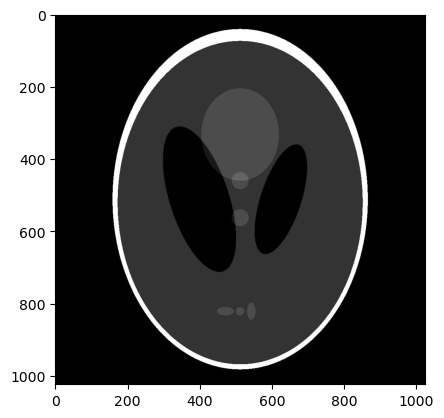

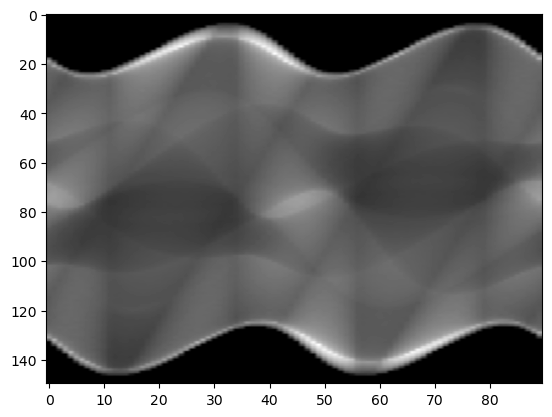

In [4]:
sinogram = np.zeros((int(2 * np.pi / INTERVAL), DETECTORS_NUMBER))
image = imread("./images/Shepp_logan.jpg")
image = color.rgb2gray(image)
X = image.shape[0] / 2 # współrzędna X środka obrazka
Y = image.shape[1] / 2  # współrzędna Y środka obrazka
R = np.sqrt(X ** 2 + Y ** 2)  # długość promienia okręgu, po którym będzie "poruszać się" emitter

# W zewnętrznej pętli wyznaczamy kolejne pozycje emitera, będą one o 0 do 2pi z odstępem co INTERVAL
for emitter_idx, emitter_angle in zip(range(int(2 * np.pi / INTERVAL)), np.arange(0, 2 * np.pi, INTERVAL)):
    # wyznaczamy współrzędne (x, y) emittera na podstawie wartości X, Y oraz R i kąta (emitter_angle) z danej interacji
    emitter_coordinates = [int(X + R * np.cos(emitter_angle)), int(Y + R * np.sin(emitter_angle))]

    # W wewnętrznej pętli wyznaczamy pozycje detectorów
    detector_start = emitter_angle + np.pi - EXTENT / 2
    detector_end = emitter_angle + np.pi + EXTENT / 2
    for detector_idx, detector_angle in zip(range(DETECTORS_NUMBER), np.arange(detector_start, detector_end, EXTENT / DETECTORS_NUMBER)):
        # wyznaczamy współrzędne (x, y) detectora
        detector_coordinates = [int(X + R * np.cos(detector_angle)), int(Y + R * np.sin(detector_angle))]

        # korzystając z algorytmu bresenham_algorithm wyliczamy punkty leżące na linii pomiędzy emitter i detector
        line_points = list(bresenham_algorithm(emitter_coordinates[0], emitter_coordinates[1],
                                               detector_coordinates[0], detector_coordinates[1]))

        points_on_line = 0  # licznik punktów które znajdują się na obrazku
        values_sum = 0
        # iterujemy po punktach wyznaczonych przed chwilą przy pomocy algorytmu bresenhama
        for point in line_points:
            if 0 <= point[0] < image.shape[0] and 0 <= point[1] < image.shape[1]:
                # jeżeli punkt należy do obrazka dodajemy 1 do licznika punktów i zwiększamy wartość sumy o wartość z punktu na obrazku wejściowym
                points_on_line += 1
                values_sum += image[point[0]][point[1]]
        if points_on_line > 0:
            # do sinogramu w odpowiednią komórkę wstawiamy wartość sumy uzyskaną w pętli powyżej podzieloną przez liczbę punktów
            sinogram[emitter_idx][detector_idx] = values_sum / points_on_line
        else:
            sinogram[emitter_idx][detector_idx] = 0

plt.imshow(image, cmap='gray')
plt.show()
plt.imshow(sinogram.T, aspect='auto', cmap='gray')
plt.show()

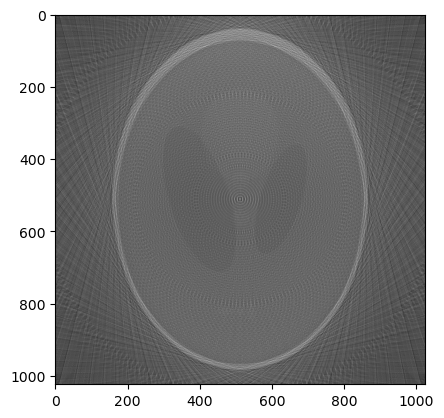

In [6]:
sinogram_f = filter_h(sinogram)
result = np.zeros(image.shape)
normalization_matrix = np.zeros(image.shape)
# Wyznaczamy obraz końcowy na podstawie powstałego sinogramu
for i in range(sinogram_f.shape[0]):
    emitter_coordinates = [int(X + R * np.cos(INTERVAL * i)), int(Y + R * np.sin(INTERVAL * i))]
    for j in range(sinogram_f.shape[1]):
        detector_angle = INTERVAL * i + np.pi - EXTENT / 2 + j * EXTENT / sinogram_f.shape[1]
        detector_coordinates = [int(X + R * np.cos(detector_angle)), int(Y + R * np.sin(detector_angle))]

        line_points = list(bresenham_algorithm(emitter_coordinates[0], emitter_coordinates[1],
                                           detector_coordinates[0], detector_coordinates[1]))

        for point in line_points:
            if 0 <= point[0] < image.shape[0] and 0 <= point[1] < image.shape[1]:
                result[point[0]][point[1]] += sinogram_f[i][j]
                normalization_matrix[point[0]][point[1]] += 1

sub_max = []
for o in result:
    sub_max.append(max(o))
norm_max = max(sub_max)

for x in range(result.shape[0]):
    for y in range(result.shape[1]):
        if normalization_matrix[x][y] != 0:
            # result[x][y] = result[x][y] / normalization_matrix[x][y]
            result[x][y] = result[x][y] / norm_max
        else:
            result[x][y] = 0

plt.imshow(result, cmap='gray')
plt.show()